# OSKM ChromVAR

Inputs:
1. Metadata for ATAC
2. ChromVAR Scores for OSKM with associated motif logos

In [1]:
library(ggplot2)
library(ggseqlogo)
library(scales)
library(patchwork)
library(cowplot)
library(scattermore)
library(reshape2)


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




## Load Inputs

### Metadata

In [2]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 62599     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,-1.8037916,-9.507773,1,D0_AAACACGCTAGTACGG
D0_AAACACGCTCTTCAAG,AAACACGCTCTTCAAG,D0,0.7074551,-9.406457,1,D0_AAACACGCTCTTCAAG
D0_AAACACGCTGATCCAT,AAACACGCTGATCCAT,D0,-2.9559933,-7.641148,1,D0_AAACACGCTGATCCAT
D0_AAACCCTGACCGCTAG,AAACCCTGACCGCTAG,D0,-3.6119107,-8.443144,1,D0_AAACCCTGACCGCTAG
D0_AAACCCTGATTGCAGT,AAACCCTGATTGCAGT,D0,0.5002119,-8.759449,3,D0_AAACCCTGATTGCAGT


### ChromVAR Scores

In [3]:
OSKM_cv = read.table("../../analysis/20200522_OSK_frip/sessions/20210717_n62599/OSKM_ChromVAR.tsv")
head(OSKM_cv)

,POU5F1,SOX2,KLF4,MYC,POU5F1.SOX2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D0_AAACACGCTAGTACGG,-0.2122726,-0.09810214,-0.11072911,0.07220178,-0.3886107
D0_AAACACGCTCTTCAAG,-0.2213217,-0.04278614,-0.09111312,0.09327532,-0.3022712
D0_AAACACGCTGATCCAT,-0.2494031,-0.07451371,-0.09690176,0.02589021,-0.3666447
D0_AAACCCTGACCGCTAG,-0.1958958,-0.12078850,-0.08822089,0.09043976,-0.3711973
D0_AAACCCTGATTGCAGT,-0.1414688,-0.02213143,-0.07480125,0.16515913,-0.2970046
D0_AAACCGTACACACCTA,-0.2181193,-0.08840394,-0.09823535,0.06612842,-0.3674076


In [4]:
all(rownames(OSKM_cv) == rownames(metaData))

[1] TRUE

### Motif PFMs

In [5]:
O_pfm = as.matrix(read.table("../../analysis/20200522_OSK_frip/data/pfms/POU5F1_MA1115.1.pfm"))
S_pfm = t(as.matrix(read.table("../../analysis/20200522_OSK_frip/data/pfms/SOX2_HUMAN.H11MO.0.A.pcm")))
K_pfm = t(as.matrix(read.table("../../analysis/20200522_OSK_frip/data/pfms/KLF4_HUMAN.H11MO.0.A.pcm")))
M_pfm = t(as.matrix(read.table("../../analysis/20200522_OSK_frip/data/pfms/MYC_HUMAN.H11MO.0.A.pcm")))
OS_pfm = as.matrix(read.table("../../analysis/20200522_OSK_frip/data/pfms/OCTSOX_MA0142.1.pfm"))

In [6]:
rownames(O_pfm) = c("A", "C", "G", "T")
rownames(S_pfm) = c("A", "C", "G", "T")
rownames(K_pfm) = c("A", "C", "G", "T")
rownames(M_pfm) = c("A", "C", "G", "T")
rownames(OS_pfm) = c("A", "C", "G", "T")

## Configs

In [91]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[9, "description"] = "Partially\nreprogrammed"

cluster_config

cluster,colour,description,new_cluster
<int>,<chr>,<chr>,<int>
1,#B03743,Fibroblast,1
2,#E85F6D,Fibroblast-like,3
3,#7C2730,Fibroblast-like,2
4,#F0A118,Intermediate,12
5,#78A824,Pre-iPSC,13
6,#A6D854,Pre-iPSC,14
7,#F01D35,Fibroblast-like,5
8,#13C4A3,iPSC,15
9,#406614,Partially reprogrammed,10


## Plotting

In [7]:
plot_chromvar <- function(dev) {
    df = data.frame(metaData, n=dev)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]
    
    p <- ggplot(df) +
    geom_scattermore(pointsize=8, aes(x=umap1 , y=umap2, col=n), pixels=c(3000,3000)) +
    scale_color_viridis_c(limit=c(quantile(dev, 0.1),
                                  quantile(dev, 0.95)), 
                          oob = squish, name='ChromVAR \nDeviation\n',
                         option="A") +
#     ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              legend.position="none", #"bottom",
#               legend.justification = "right",
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()
    
    p
}

In [36]:
GENE = "POU5F1.SOX2"
logo_pfm = OS_pfm

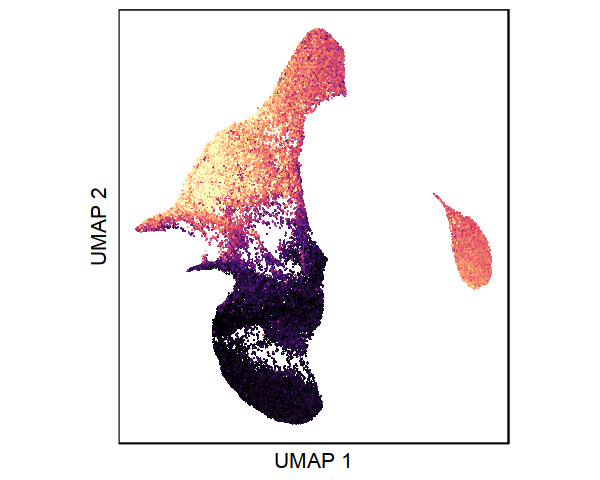

In [37]:
options(repr.plot.width = 5, repr.plot.height = 4)

umap_plot <- plot_chromvar(OSKM_cv[,GENE])

umap_plot

In [38]:
legend = cowplot::get_legend(umap_plot + theme(legend.position="bottom", 
                                               legend.text=element_text(angle=90, hjust=1)))

In [39]:
options(repr.plot.width = 2, repr.plot.height = 1)

logo <- ggseqlogo(as.matrix(logo_pfm)) +
scale_y_continuous(expand = c(0, 0)) +
theme(axis.text.x = element_blank(),
     axis.text.y = element_blank(),
     axis.title.y = element_blank(), 
#       plot.background = element_rect(fill = 'green', colour = 'red'), # for visualizing padding
     axis.ticks.length = unit(0, "pt"), #length of tick marks
     panel.grid.major=element_blank(),
     panel.grid.minor=element_blank(),
     plot.margin = margin(5, -10, -10, 0, "pt"))

logo_w_legend = wrap_plots(#plot_spacer(), 
                           logo,
                           legend,
                           #plot_spacer(), 
                           widths=c(2,3))

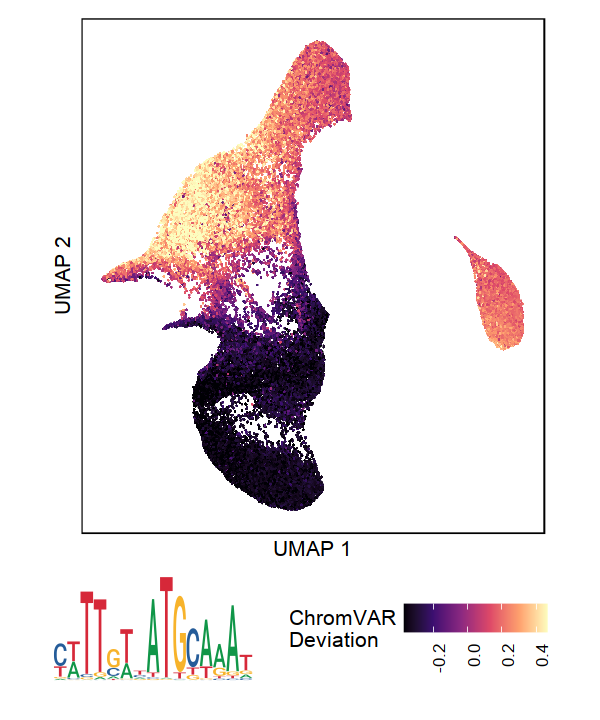

In [40]:
options(repr.plot.width = 5, repr.plot.height = 6)

combined_plot <- wrap_plots(umap_plot,
                            logo_w_legend,
                            heights=c(5,1))

combined_plot

In [41]:
saveRDS(combined_plot, file=sprintf("./subfigs/%s_%s_chromvar.rds",
                                   format(Sys.Date(), "%Y%m%d"), GENE))

In [42]:
# ggsave(combined_plot, file=sprintf("./subfigs/%s_%s_chromvar.pdf",
#                                    format(Sys.Date(), "%Y%m%d"), GENE),
#       height=6, width=5)

## Per State Plots

In [71]:
colnames(OSKM_cv)

[1] "POU5F1"      "SOX2"        "KLF4"        "MYC"         "POU5F1.SOX2"

In [113]:
cluster_config

cluster,colour,description,new_cluster
<int>,<chr>,<chr>,<int>
1,#B03743,Fibroblast,1
2,#E85F6D,Fibroblast-like,3
3,#7C2730,Fibroblast-like,2
4,#F0A118,Intermediate,12
5,#78A824,Pre-iPSC,13
6,#A6D854,Pre-iPSC,14
7,#F01D35,Fibroblast-like,5
8,#13C4A3,iPSC,15
9,#406614,Partially reprogrammed,10


In [126]:
vals = c()
motifs = c()

motifs_subset = c('POU5F1','SOX2','POU5F1.SOX2','KLF4')

for (x in motifs_subset) {    
    cur_vals = OSKM_cv[,x]
    # min (0.1) - max (0.95) normalize
    cur_vals = cur_vals - quantile(cur_vals, .1)
    cur_vals[cur_vals<0] = 0
    cur_vals = cur_vals/quantile(cur_vals, .95)
    cur_vals[cur_vals>1] = 1
    
    vals = c(vals, cur_vals)
    motifs = c(motifs, rep(x, nrow(OSKM_cv)))
}

all_clusts = paste(cluster_config[metaData$cluster, "new_cluster"], cluster_config[metaData$cluster, "description"], sep='\n')

clust_levels = paste(cluster_config$new_cluster, cluster_config$description, sep='\n')[order(cluster_config$new_cluster)]


per_state_df = data.frame(clusters = factor(rep(all_clusts, length(motifs_subset)), levels=clust_levels),
                          vals=vals, 
                          motifs=factor(motifs, levels=motifs_subset))

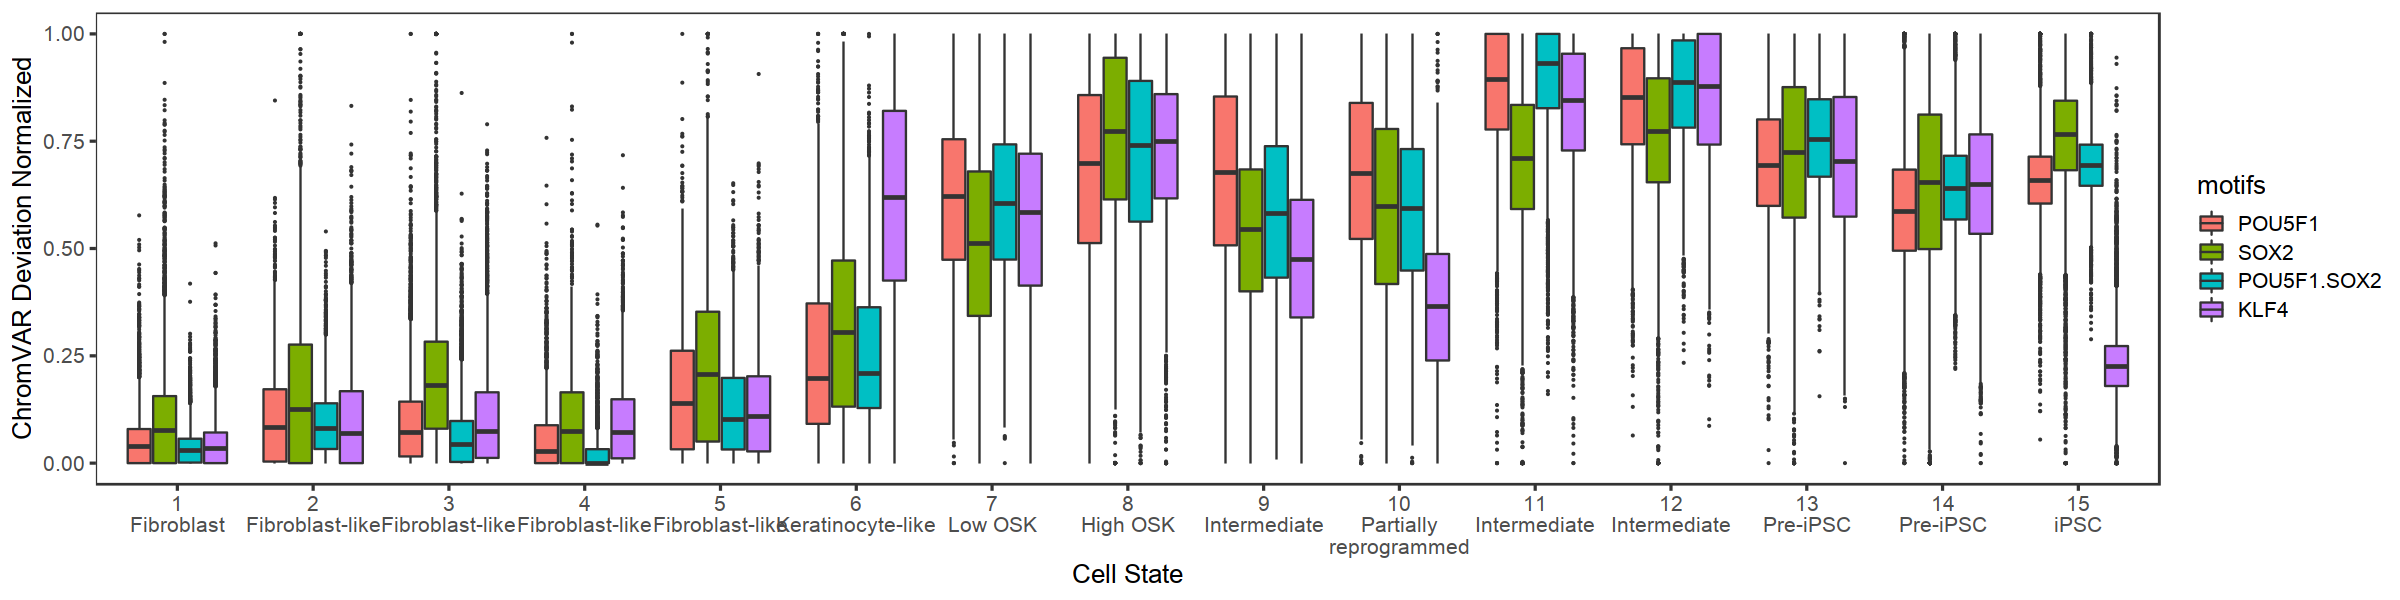

In [147]:
options(repr.plot.width = 20, repr.plot.height = 5)

per_state_cv = ggplot(per_state_df) +
    geom_boxplot(aes(x=factor(clusters), y=vals, fill=motifs), outlier.size=0.1) + # for violin: scale='width')  +
    theme_bw(base_size = 15) +
    theme(panel.grid.major=element_blank(),
         panel.grid.minor=element_blank()) +
    ylab("ChromVAR Deviation Normalized") +
    xlab("Cell State") 

per_state_cv

In [149]:
ggsave(per_state_cv, file="./subfigs/per_state_chromvar.pdf", height=5, width=20, useDingbats=F)

---

In [32]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] reshape2_1.4.4  scattermore_0.7 cowplot_1.0.0   patchwork_1.0.0
[5] scales_1.1.0    ggseqlogo_0.1   ggplot2_3.3.3  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5        pillar_1.4.6      compiler_3.6.3    plyr_1.8.6       
 [5] base64enc_0.1-3   tools_3.6.3       digest_0.6.25    

Code below not used.

## Clustering

In [64]:
library(ClusterR)
library(matrixStats)

In [71]:
colMins(as.matrix(OSKM_cv))

[1] -0.4996788 -0.3007062 -0.2372663 -0.5501412 -0.6376490

In [177]:
OSKM_scaled = t(as.matrix(t(OSKM_cv) - apply(OSKM_cv, 2, function(x) {quantile(x, .02)})))
OSKM_scaled[OSKM_scaled<0] = 0 
OSKM_scaled = OSKM_scaled/apply(OSKM_scaled, 2, function(x) {quantile(x, .9995)})
OSKM_scaled[OSKM_scaled>1] = 1

In [178]:
colMins(OSKM_scaled)
colMaxs(OSKM_scaled)

[1] 0 0 0 0 0

[1] 1 1 1 1 1

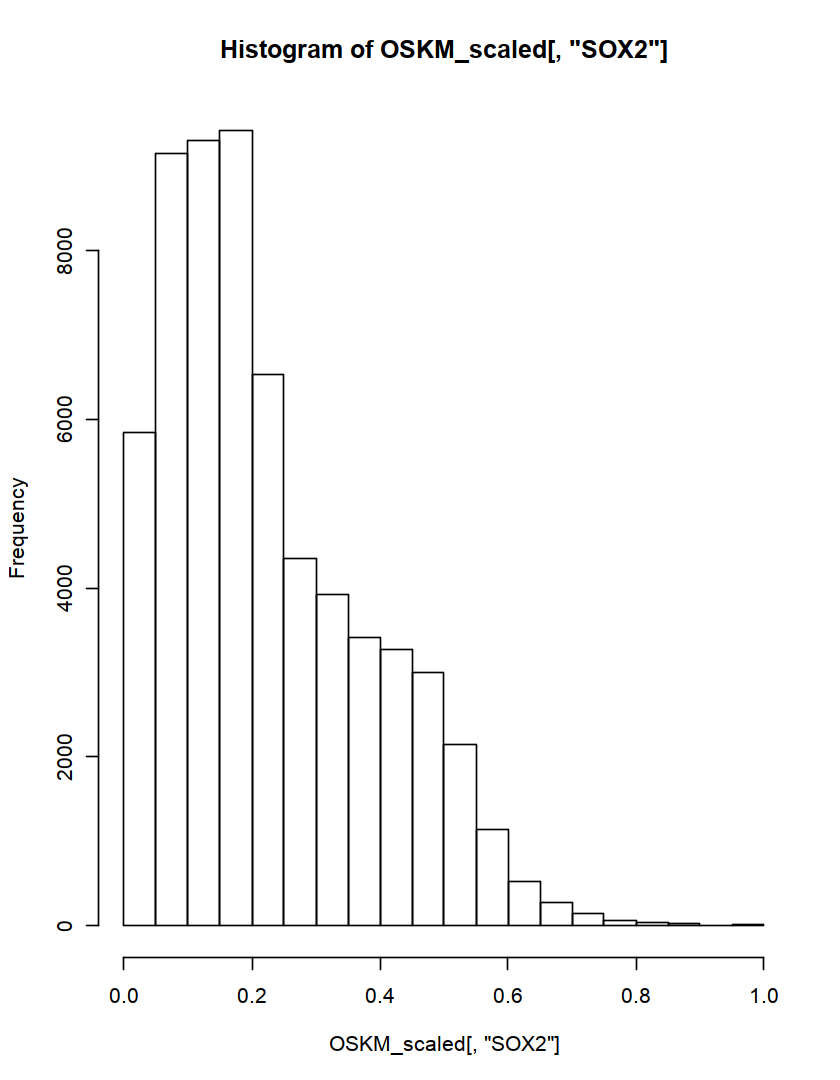

In [179]:
hist(OSKM_scaled[,"SOX2"])

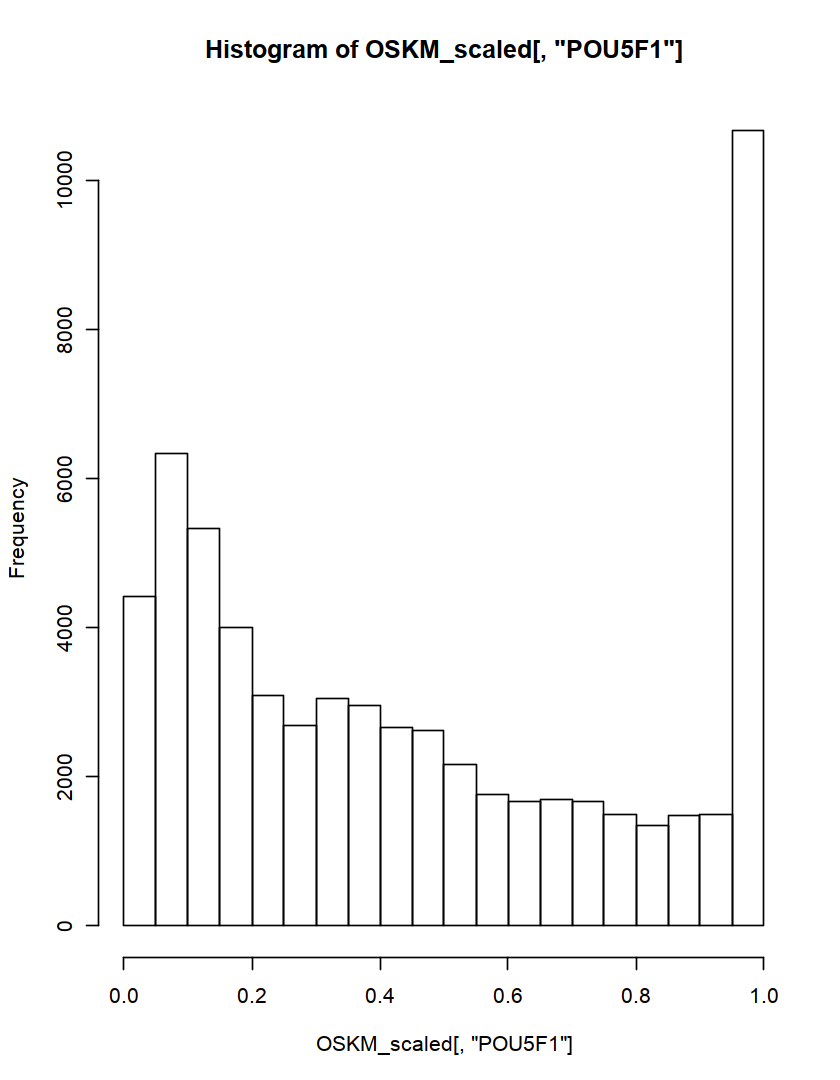

In [180]:
hist(OSKM_scaled[,"POU5F1"])

In [181]:
NUM_PEAK_SETS = 8
km_mb = MiniBatchKmeans(OSKM_scaled[, 1:3], 
                        batch_size = 1000,
                        clusters = NUM_PEAK_SETS,
                        num_init = 50, 
                        verbose = FALSE)

In [182]:
pr_mb = predict_MBatchKMeans(OSKM_scaled[,1:3], km_mb$centroids)

In [183]:
# sort centroids by average expr and renumber
pr_mb = order(order(rowSums(km_mb$centroids)))[pr_mb]

In [184]:
sort(table(pr_mb))

pr_mb
    8     3     5     4     7     6     2     1 
 3722  5781  5836  7201  7428  7656  7987 16988 

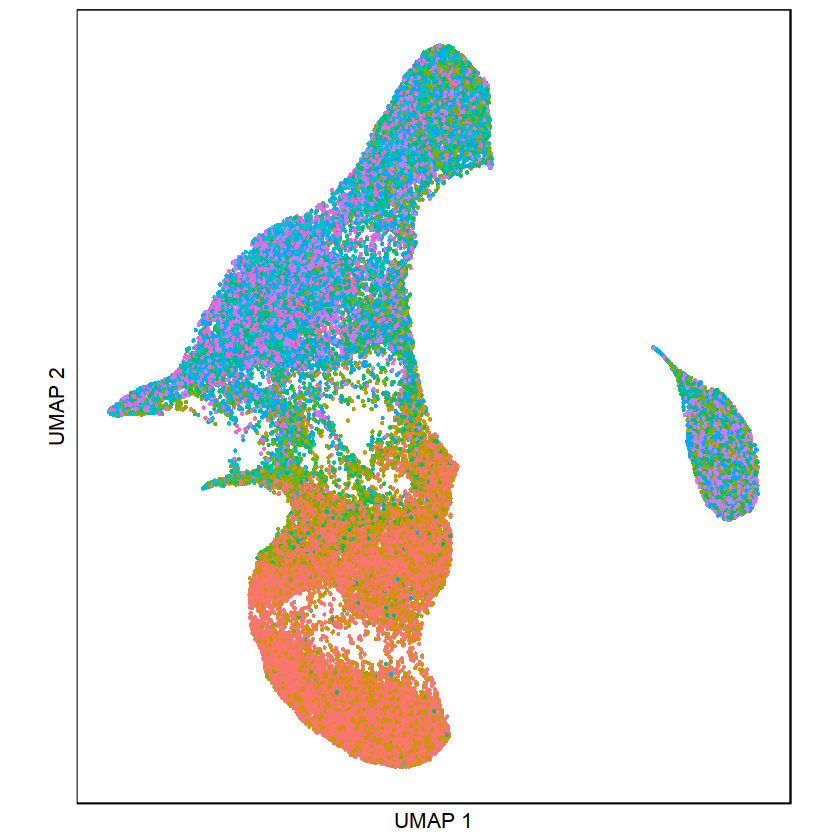

In [185]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(metaData, n=pr_mb)

ggplot(df) +
    geom_scattermore(pointsize=8, aes(x=umap1 , y=umap2, col=factor(n)), pixels=c(3000,3000)) +
#     ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              legend.position="none", #"bottom",
#               legend.justification = "right",
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()

In [186]:
km_mb$centroids[order(rowSums(km_mb$centroids)), ]

0.08320499,0.09368981,0.07442571
0.25635967,0.12749621,0.06192149
0.30787739,0.25905803,0.27448866
0.55483902,0.16889240,0.28564056
0.43388210,0.32168437,0.54396880
0.97241482,0.21863007,0.16409282
0.90363744,0.48405852,0.23156683
0.83184865,0.43214046,0.61987058


In [187]:
LABELS = c("None", 
           "Mid M",
           "Mid OS",
           "Mid OM",
           "High KM", 
           "Mid OSKM", 
           "High OSKM", 
           "Very high OSK")

COLORS = c("#6f1000", 
           "#fdc086",
           "#29C460",
           "#5762D5",
           "#00A7E1",
           "black",
           "cadetblue2",
           "#f0027f"
          )

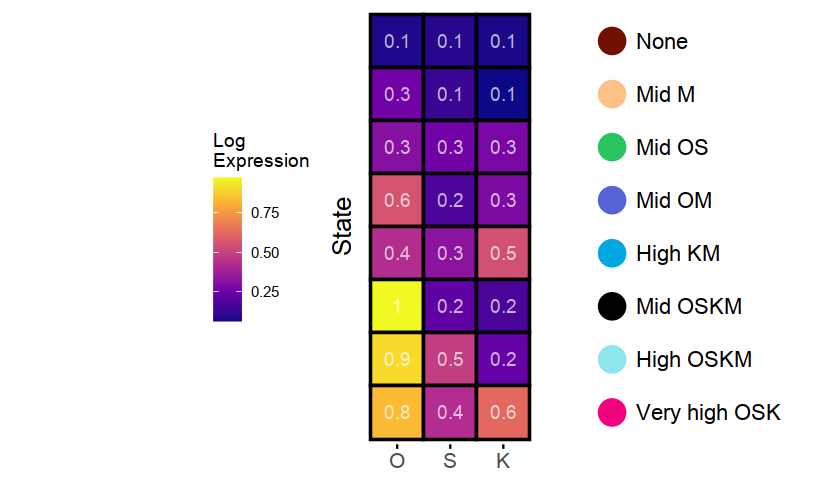

In [188]:
options(repr.plot.width = 7, repr.plot.height = 4)

centroids = km_mb$centroids
centroids = centroids[order(rowSums(centroids)), ]
colnames(centroids) = c("O", "S", "K")
centroids = melt(centroids)
centroids$Var1 = factor(centroids$Var1, levels=rev(seq(NUM_PEAK_SETS)))
centroids$rounded = round(centroids$value, digits=1)

legend_plot <- ggplot(centroids) +
geom_tile(aes(x=Var2, 
              y=Var1, 
              fill=value),
         col="black", size=.75) +
scale_fill_viridis_c(option = "C", name="Log\nExpression") +

geom_text(aes(x=Var2, y=Var1, label=rounded, colour=(rounded>2)), alpha=.7) +
scale_colour_manual(values = c("white", "black")) +

xlab(NULL) + 
ylab("State") +
theme_minimal() +
coord_fixed(clip="off") +
guides(colour=FALSE) +
theme(axis.ticks.x = element_line(colour = "black"),
     axis.text=element_text(size=12),
     axis.text.y = element_blank(),
     axis.title=element_text(size=15),
     legend.position="left",
     panel.grid.major = element_blank())

for (i in seq(length(LABELS))) {
    legend_plot <- legend_plot + annotate(geom = "point", 
                                          x = 5.05, y = (NUM_PEAK_SETS-i+1),
                                         colour = COLORS[i], 
                                         size = 7)
    legend_plot <- legend_plot + annotate("text", 
                                          x=5.5, 
                                          y=(NUM_PEAK_SETS-i+1), 
                                          label=LABELS[i], 
                                          hjust=0,
                                         size=4.5)
}

legend_plot

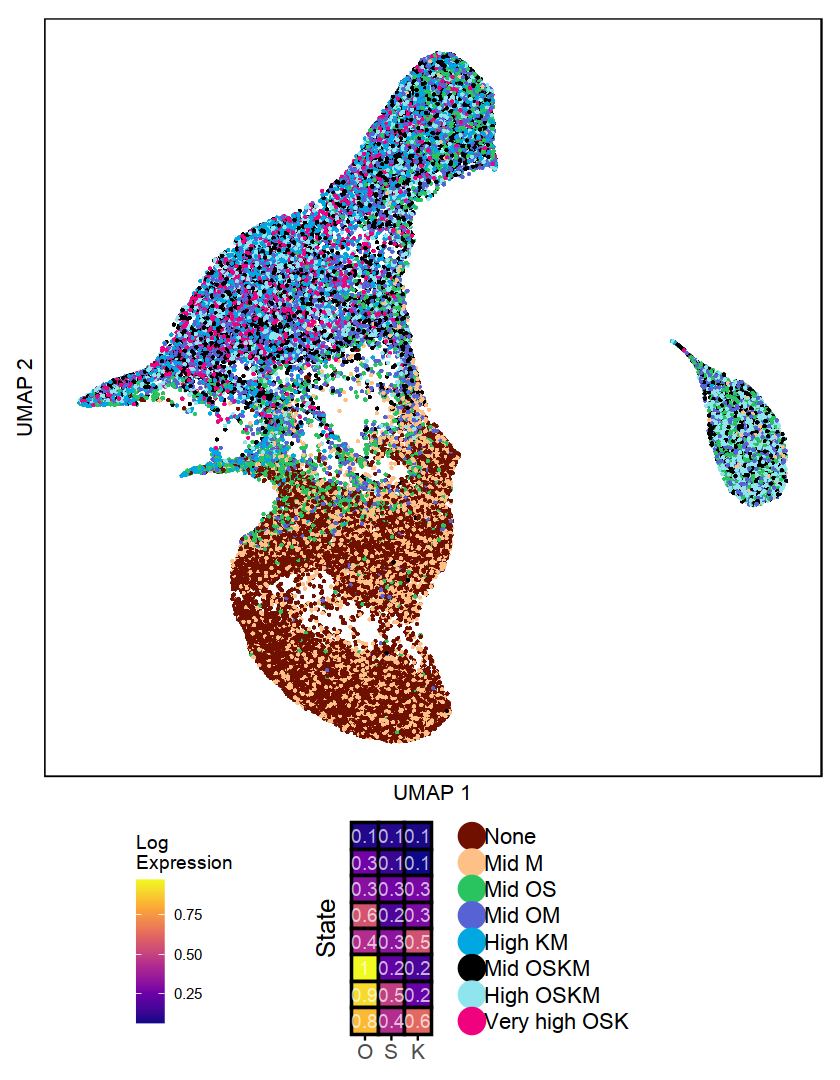

In [189]:
options(repr.plot.width = 7, repr.plot.height = 9)

# TODO: stoichiometry papers v high OSKM = non reprog?
# switching off of exogenous K at late stage

state_plot_coloured = ggplot(df) +
    geom_scattermore(pointsize=8, aes(x=umap1 , y=umap2, col=factor(n)), pixels=c(3000,3000)) +
#     ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              legend.position="none", #"bottom",
#               legend.justification = "right",
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    scale_color_manual(values=COLORS) +
    theme(legend.position="none") 

combined_plot <- wrap_plots(state_plot_coloured,
          wrap_plots(plot_spacer(), legend_plot, plot_spacer(), widths=c(0.5,2,2)),
          heights=c(7,2))

combined_plot